In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import os
import datetime as dt
import numpy as np
from copy import deepcopy
import seaborn as sns
from IPython.display import display

# Load

In [135]:
files = os.listdir("data")
# Sort dates
dates = [dt.datetime.strptime(re.findall(r'\d{4}-\d{2}-\d{2}',f)[0],'%Y-%m-%d') for f in files]
dates = sorted(dates,reverse=False)
dates = [i.strftime('%Y-%m-%d') for i in dates]
# Create a dict with keys are dates and values are data of those dates
dfs_raw = {d: pd.read_csv(f'data/worldometers-{d}.tsv',sep="\t") for d in dates}

# Preprocess

In [13]:
dfs = deepcopy(dfs_raw)
for df in dfs.values():
    for i in range(1, df.shape[1] - 1):
        # Fill nan in numerical data with 0
        df.iloc[:,i] = df.iloc[:,i].fillna(0)
    # Fill categorical nan with Other
    df.iloc[:,-1] = df.iloc[:,-1].fillna('Other')
    df.iloc[:,0] = df.iloc[:,0].fillna('Other')    

# Trend

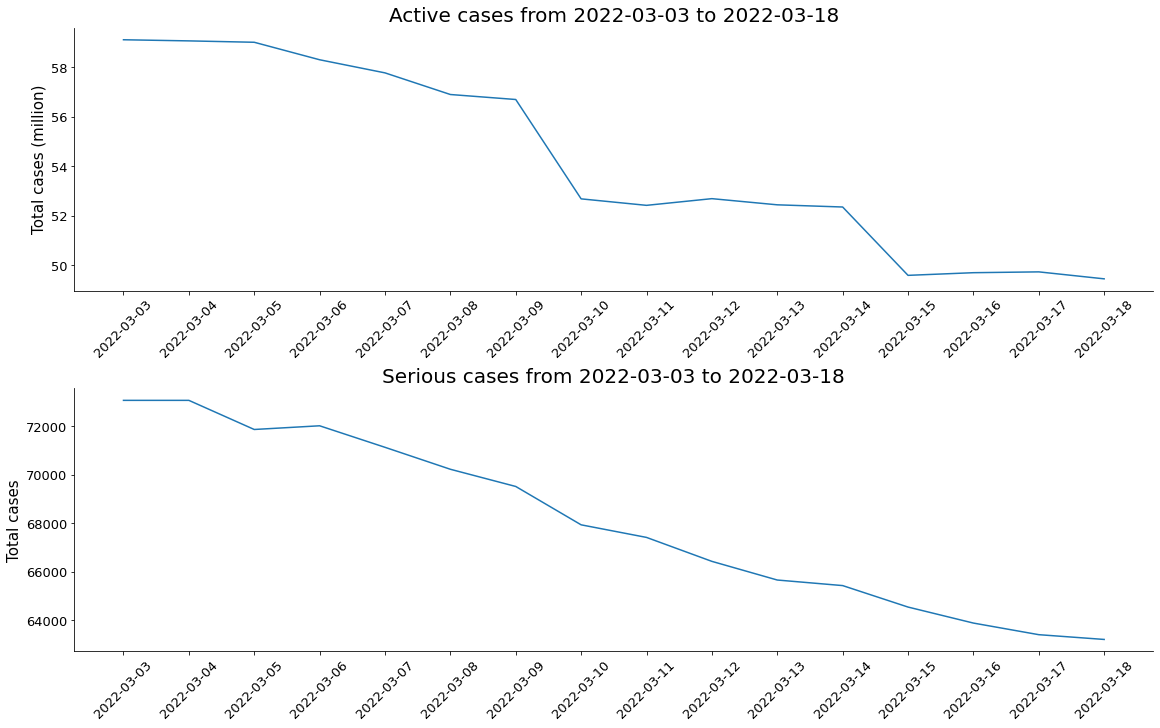

In [25]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,10),constrained_layout = True)

ax1.tick_params(axis='x', labelrotation=45)
ax1.ticklabel_format(style='plain') # remove scientific notation for ticks label
ax1.spines[['right','top']].set_visible(False) # remove redundancies to improve focus
ax1.set_title(f"Active cases from {dates[0]} to {dates[-1]}",fontsize=20)

t = np.fromiter([dfs[d]['ActiveCases'].sum() for d in dates],dtype=int)
ax1.plot(dates, t/10**6) # normalize data so as to remove confusion
ax1.tick_params(labelsize=13)
ax1.set_ylabel('Total cases (million)',fontsize=15)

ax2.tick_params(axis='x', labelrotation=45)
ax2.ticklabel_format(style='plain') # remove scientific notation for ticks label
ax2.spines[['right','top']].set_visible(False) # remove redundancies to improve focus
ax2.set_title(f"Serious cases from {dates[0]} to {dates[-1]}", fontsize=20)
ax2.plot(dates, [dfs[d]['Serious,Critical'].sum() for d in dates])
ax2.tick_params(labelsize=13)
ax2.set_ylabel('Total cases',fontsize=15)

# Save figures
fig.savefig("figures/Active-Serious-Trend")

# Continents' active, serious cases latest date

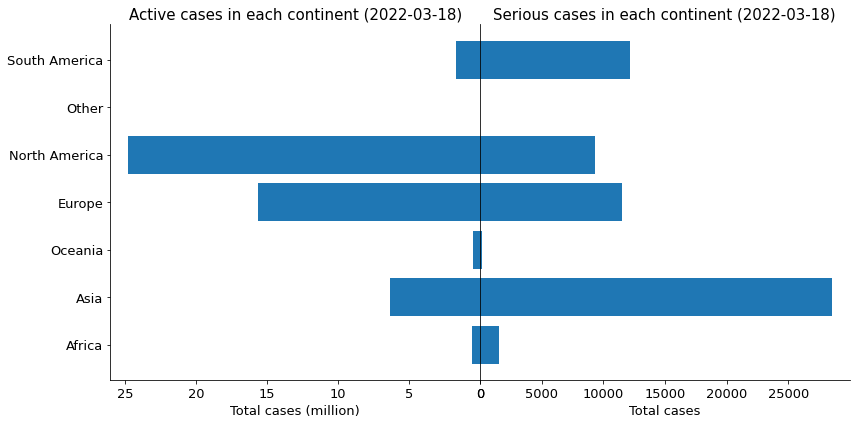

In [133]:
ActiveCasesContinent = dfs[dates[-1]][['Continent','ActiveCases']].groupby(by='Continent').agg(['sum'])
SeriousCasesContinent = dfs[dates[-1]][['Continent','Serious,Critical']].groupby(by='Continent').agg(['sum'])
x_labels = ['Africa','Asia', 'Oceania', 'Europe', 'North America', 'Other', 'South America']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout()

t = np.round(ActiveCasesContinent.values.reshape((1, -1))[0]/10**6,2)
bars = ax1.barh(x_labels, t)
ax1.invert_xaxis()
ax1.spines['top'].set_visible(False) # remove redundancies to improve focus
ax1.ticklabel_format(axis='x', style='plain') # remove scientific notation for ticks label
ax1.set_title(f"Active cases in each continent ({dates[-1]})",fontsize=15)
ax1.tick_params(labelsize=13)
ax1.set_xlabel('Total cases (million)',fontsize=13)

t = SeriousCasesContinent.values.reshape((1, -1))[0]
bars = ax2.barh(x_labels, t)
ax2.spines[['right','top']].set_visible(False)  # remove redundancies to improve focus
ax2.ticklabel_format(axis='x', style='plain') # remove scientific notation for ticks label
ax2.set_title(f"Serious cases in each continent ({dates[-1]})",fontsize=15)
ax2.set_xlabel('Total cases',fontsize=13)
ax2.tick_params(labelsize=13)
ax2.tick_params(axis='y',labelleft=False, left=False)

fig.tight_layout()
fig.subplots_adjust(wspace=0)

# save figures
fig.savefig("figures/Active-Serious-Cont")

In [17]:
df = dfs[dates[-1]]
df[df['Continent']=='Other'] 

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,Population,Continent
212,Diamond Princess,712,0.0,13.0,0.0,699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
222,MS Zaandam,9,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other


# Active cases and serious cases relationship

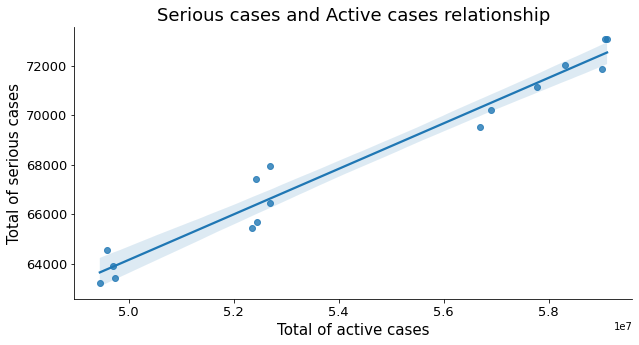

In [137]:
# Get world serious, active cases
SeriousCases = np.fromiter([dfs[d]['Serious,Critical'].sum() for d in dates],dtype=int)
ActiveCases = np.fromiter([dfs[d]['ActiveCases'].sum() for d in dates],dtype=int)

fig, ax = plt.subplots(1,1,figsize=(10,5))
# Each data point is the data of a date
sns.regplot(x=ActiveCases,y=SeriousCases, ax=ax)
ax.spines[['right','top']].set_visible(False)
ax.set_ylabel("Total of serious cases", fontsize=15)
ax.set_xlabel("Total of active cases", fontsize=15)
ax.set_title("Serious cases and Active cases relationship", fontsize=18)
ax.tick_params(labelsize=13)

# Save figures
fig.savefig("figures/Active-Serious-Rel")